<div style="text-align:center; font-family:sans-serif; line-height:1.6;">
  <h1 style="color:#F14925; font-size:2.5em; margin-bottom:0.3em;">
    Physics-Informed Neural Networks (PINNs)
  </h1>
  
  <p style="font-size:1.8em; margin:0.2em 0;">
    Juan Calles - <a href="mailto:juan.calles@uv.cl" style="color:inherit; text-decoration:none;">juan.calles@uv.cl</a>
  </p>
  
  <p style="font-size:1.5em; font-weight:bold; margin-top:1em;">
    Escuela de Física Teórica de Valparaíso
  </p>
  
  <p style="font-size:1.3em; margin:0.2em 0;">
    3 - 4 - 5 de Diciembre de 2025
  </p>
  <p style="font-size:1.3em; margin:0.2em 0;">
    Facultad de Ciencias y Edificio CIAE
  </p>
  <p style="font-size:1.3em; margin:0.2em 0;">
    Universidad de Valparaíso
  </p>
</div>

# Requisitos y ejecución

En esta sesión utilizaremos `PyTorch` para construir y entrenar redes neuronales.
Asumiremos que ya tienes familiaridad con las siguientes herramientas:

 - Github
 - Python
 - Jupyter notebooks
 - Numpy, Matplotlib, scipy
 - pytorch

Existen, sin embargo, otras alternativas ampliamente utilizadas en investigación y la industria:

1. [TensorFlow/Keras](https://www.tensorflow.org/)
1. [JAX](https://docs.jax.dev/en/latest/notebooks/thinking_in_jax.html) 
1. [SciML-Julia](https://sciml.ai/) 

Además de las herramientas mencionadas, este notebook asume que tienes nociones básicas de lo siguiente:

- Neural network (NN)
- Multilayer Perceptron (MLP)
- Entrenamiento de una NN -> Regresión/Clasificación

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.set_default_device("cuda")

## 🔢 Punto de partida: ¡Necesitamos datos!

Para comenzar cualquier proceso de modelado o análisis, lo primero que necesitamos son datos! 

Típicamente, estos se presentan como:

- **Entradas (inputs)**: $x_{1:N}=(x_1,x_2,...,x_N)$ 
    - donde cada $x_i$ representa una observación o conjunto de características.

- **Salidas (outputs)**: $y_{1:N}=(y_1,y_2,...,y_N)$ 
    - que corresponden a las respuestas, etiquetas o valores asociados a cada entrada.

Este par $\mathcal{D} = \{x_i,\, y_i\}_{i=1}^{N}$ forma lo que llamamos una muestra (*sample*) de entrenamiento, y el conjunto completo de pares nos permite aprender patrones estadísticos, ajustar modelos, o validar hipótesis que **expliquen el proceso que generaron los outputs**!.

🎯 Objetivo: simular una señal tipo seno con ruido gaussiano

Antes de aplicar cualquier modelo, vamos a generar nuestros propios datos. Estos datos serán **sintéticos**, es decir, **creados artificialmente** en lugar de recolectados del mundo real. 

¿Por qué usar datos sintéticos?

- Control total: Podemos definir exactamente la estructura, el ruido (noise) y las **propiedades estadísticas**.
- Validación de modelos: Son ideales para probar si un modelo puede recuperar patrones conocidos.
- Diagnóstico pedagógico: Permiten ilustrar conceptos sin depender de datos externos o complicaciones reales.

Vamos a generar $N$ puntos de entrada $x_i$ distribuidos uniformemente en un intervalo (por ejemplo, $[0, 2\pi]$), y para cada uno calcularemos una salida $y_i$ como:

$$y_i = \sin(x_i) + \epsilon_i$$

donde $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ es ruido Gaussiano/Normal con media cero y varianza $\sigma^2$.

Esto nos da un conjunto de datos $\{x_i,\, y_i\}$ que **emula** una señal periódica con perturbaciones aleatorias.


> Nota: Estos datos podrían representar, por ejemplo, una **simulación de temperaturas** en Valparaíso durante un día de verano.  
> Si ajustamos la función seno para oscilar en torno a una **temperatura media de 18 °C**, el eje $x_i \in [0, 2\pi]$ representaría las horas del día (un ciclo), con un máximo en $x=\pi/2$ corresponderia a las 5 P.M. aproximadamente.  
> Así, el conjunto de datos, **generados por una "simulación"** (una simulación SUPER simplificada), corresponderian a una señal periódica con ruido y permitiría **evaluar modelos de predicción de temperatura**, considerando las variaciones diarias aleatorias.


In [ ]:
# Completar la siguiente función para que genere un conjunto de datos sintéticos que emule una distribución seno + ruido gaussiano
def generar_datos(num_puntos, desviacion_ruido=0.1):
    # Generar valores aleatorios para x
    valores_x = np.sort(np.random.uniform(0, 2 * np.pi, num_puntos))
    # Generar los correspondientes valores de y = sen(x) + N(0, desviación)
    valores_y = np.sin(valores_x) + np.random.normal(0, desviacion_ruido, num_puntos)
    return valores_x, valores_y

num_puntos = 1000

# Agregue un parámetro a la función que module el nivel de ruido de los datos atraves de la desviación estandard sigma
x_train, y_train= generar_datos(num_puntos, desviacion_ruido=0.1)


Antes de entrenar cualquier modelo, lo más importante es visualizar y entender cómo lucen nuestros datos. Esto nos permite detectar patrones, outliers, ruido o posibles errores de generación.

<div style="border-left: 4px solid #4caf50; padding: 8px;">
💡 <strong>Nota:</strong> Cuando los datos son "sintéticos" tenemos la ventaja de conocer la distribución exacta que deberían seguir.
</div>

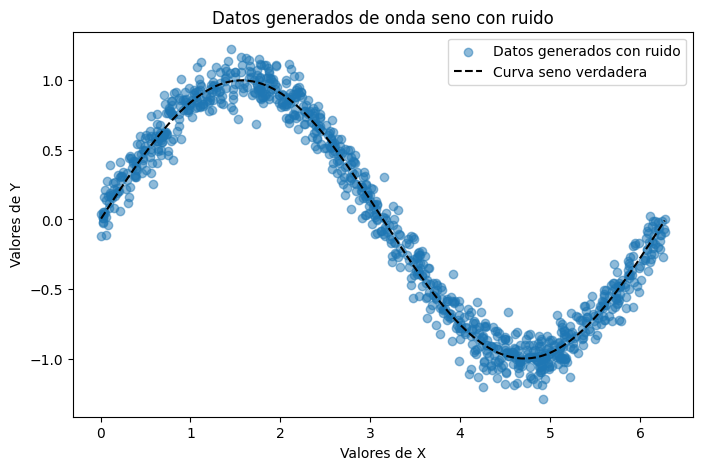

In [ ]:
# Gráfico simple de los datos vs. la función real
plt.figure(figsize=(8, 5))

plt.scatter(x_train, y_train, label='Datos generados con ruido', alpha=0.5)
plt.plot(x_train, np.sin(x_train), color='k', linestyle='--',label='Curva seno verdadera')

plt.legend()
plt.title('Datos generados de onda seno con ruido')
plt.xlabel('Valores de X')
plt.ylabel('Valores de Y')
plt.show()

## 🕸️ Red Neuronal

Nuestro objetivo ahora es construir una red neuronal capaz de **aprender** a ajustar los datos sintéticos generados previamente.
Para ello, implementaremos un Perceptrón Multicapa (MLP, *Multilayer Perceptron*), que es la forma más básica de red neuronal.

> Un MLP está formado por varias capas lineales (*fully connected layers*), donde cada neurona se conecta con todas las de la capa anterior.
>
> Entre estas capas se insertan funciones de activación que introducen *no linealidad*, permitiendo que la red aprenda relaciones complejas entre entrada y salida.

En términos generales, nuestro modelo puede entenderse como una función, $\hat{y}$, parametrizada por los pesos(weights) y sesgos(biases) de la red $(w_{ij}, b_i)$, que agrupamos bajo el símbolo $\theta$. Así, la red $\hat{y}_\theta$ representa una función que depende de estos parámetros, toma como entrada los valores $x_i$, y produce como salida las predicciones correspondientes.

Arquitectura propuesta

 * **Capa 1:** Lineal, transforma las entradas en una representación de dimensión intermedia.
 * **Función de activación:** puede ser `ReLU` (más simple y rápida) o `Tanh` (más suave y útil para funciones continuas).
 * **Capa 2:** Lineal, genera la salida final del modelo.

Ayuda:

```python
    nn.Linear(input,output)
    nn.Conv2d(input,output)
    nn.functional.tanh
    nn.function.relu
    nn.function.softmax
```

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1, 10)          # Fully connected layer: 1 input feature, 10 hidden units
        self.activation = nn.functional.tanh # Función de activación
        self.fc2 = nn.Linear(10, 1)          # Fully connected layer: 10 hidden units, 1 output

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

🧠 ¿Cómo entrenamos nuestro modelo?

“*Aprender*” significa ajustar los parámetros internos de la red, denotados por $\theta$, para que las predicciones $\hat{y}_i$ se acerquen lo más posible a los valores reales $y_i$.
Este proceso se basa en dos componentes esenciales:

 1. **Minimización de una función de costo (Loss function):** 

    Para medir qué tan bien está funcionando el modelo, usamos una función de costo que cuantifica el error entre las predicciones y los datos reales.
    Una de las más comunes es el Error Cuadrático Medio (MSE):

    $$
    \mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} \left( y_i - \hat{y}_i \right)^2
    $$
    donde $y_i$ es el valor real y $\hat{y}_i$ es la predicción del modelo para la entrada $x_i$.
    > Notenemos que necesitamos 3 argumentos $\{x_i,\hat{y}(x_i),y(x_i)\}$ para evaluar esta función!

 2. **Actualización por descenso del gradiente:**

    Para encontrar los valores óptimos de los parámetros del modelo, $\theta$, que minimizan la función de costo, $\mathcal{L}$, se utiliza el método de descenso del gradient (*gradient descent*).
    La idea central es mover los parámetros en la dirección opuesta al gradiente de la pérdida, es decir, en la dirección que más reduce el error:

    $$
    \theta_{t+1} = \theta_t - \eta \nabla_\theta \mathcal{L}
    $$

    donde:

     * $\eta$ es la tasa de aprendizaje (*learning rate*), que controla qué tan grande es cada paso de actualización.

     * $\nabla_\theta \mathcal{L}$ es el gradiente de la pérdida respecto a los parámetros del modelo.

        * Este gradiente indica la dirección de mayor aumento de la pérdida; por eso se resta en la actualización.
        * En la práctica, los gradientes se calculan mediante **diferenciación automática** (*automatic differentiation*) en librerías como *PyTorch* o *TensorFlow*.

    Existen distintos optimizadores que implementan variantes del descenso del gradiente:

     * **SGD (Stochastic Gradient Descent)**: usa un subconjunto aleatorio de datos en cada iteración.
     * **RMSProp**: ajusta dinámicamente el tamaño de paso para cada parámetro según la magnitud reciente de sus gradientes.
     * **Adam**: combina las ideas de *momentum* y escalamiento adaptativo de tasa de aprendizaje, siendo hoy el más popular por su estabilidad y rapidez de convergencia.

Este ciclo: *calcular la pérdida → obtener los gradientes → actualizar parámetros*, se repite iterativamente hasta que:

* la pérdida sea lo suficientemente baja,
* el modelo converja, o
* se alcance el número máximo de iteraciones.

<div style="border-left: 4px solid #4caf50; padding: 8px;">
💡 <strong>En términos simples:</strong> el modelo aprende a ajustar $\theta$, repitiendo pequeños pasos en la dirección "correcta", hasta que $\hat{y}_\theta$ se ajusta a los datos.
</div>


In [ ]:
# Ahora definimos en Pytorch nuestro código para entrenar la red:
def train_epoch(inputs, model, targets, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.item()

# Ademas agregamos una pequeña función que nos ayuda a evaluar el model
def evaluate(model, x_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(x_test).cpu().numpy()
    return y_pred.squeeze()

In [ ]:
# Iniciamos las instancias correspondientes
modelo       = MLP()
criterio     = nn.MSELoss()
optimizador  = optim.Adam(modelo.parameters(), lr=1e-2)

#numero de parametros de la red
numero_parametros = sum(p.numel() for p in modelo.parameters())
print(f"Number of parameters: {numero_parametros}")

Number of parameters: 31


In [ ]:
# Y ahora definimos el loop 'iterativo' de entrenamiento
num_epocas = 1000
for epoca in range(num_epocas):
    # Convertimos los datos a Tensores de pytorch
    x_i  = torch.tensor(x_train[:,None], dtype=torch.float32)  #inputs shape (Npuntos,1) 
    y = torch.tensor(y_train[:,None], dtype=torch.float32)     #targets shape (Npuntos,1) 

    # Entrenamos
    loss = train_epoch(x_i, modelo, y, optimizador, criterio)

    if (epoca+1) % 100 == 0:
        print(f'Epoch [{epoca+1}/{num_epocas}], Loss: {loss:.4f}')

Epoch [100/1000], Loss: 0.0941
Epoch [200/1000], Loss: 0.0522
Epoch [300/1000], Loss: 0.0293
Epoch [400/1000], Loss: 0.0164
Epoch [500/1000], Loss: 0.0117
Epoch [600/1000], Loss: 0.0107
Epoch [700/1000], Loss: 0.0105
Epoch [800/1000], Loss: 0.0104
Epoch [900/1000], Loss: 0.0104
Epoch [1000/1000], Loss: 0.0103


Ya tenemos nuestro modelo entrenado! Pero… **¿realmente aprendió algo útil?**

Para responderlo, haremos una inspección visual de las predicciones $\hat{y}_i$ generadas por la red.

📈 Una visualización típica incluye:

 1. **Datos de entrenamiento:** los puntos originales $(x_i, y_i)$, que representan nuestras observaciones.
 2. **Predicción del modelo:** la función $\hat{y}(x_{\text{new}})$ evaluada en un conjunto de puntos nuevos y más densos, para ver la forma continua que aprendió.
 3. **Solución real (si la conocemos):** $y(x_{\text{new}})$ evaluada en los mismos puntos del paso anterior, para comparar con la salida de la red.

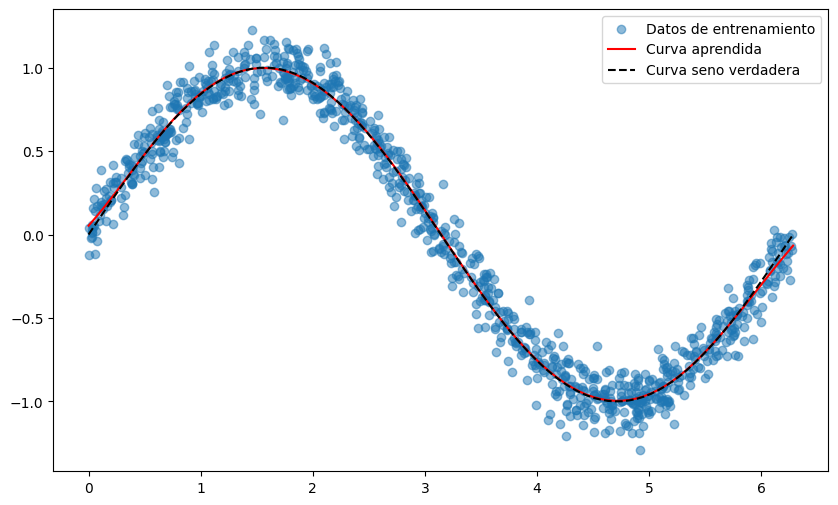

In [ ]:
x_test = torch.linspace(0, 2*np.pi, 100) # x_nuevos
y_pred = evaluate(modelo, x_test[:,None]) # Nuestro modelo evaluado en los nuevos puntos x

x_test = x_test.cpu().numpy()
y_test = np.sin(x_test) # Funcion verdadera evaluada en los nuevos puntos x_new

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, label='Datos de entrenamiento',alpha=0.5)
plt.plot(x_test, y_pred, label='Curva aprendida', color='red')
plt.plot(x_test, y_test, color='k', linestyle='--',label='Curva seno verdadera')

plt.legend()
plt.show()

🔍 ¿Qué podemos observar de este gráfico?

 * Si el modelo captura correctamente la forma general de la función (por ejemplo, una senoide).
 * Si existen zonas sistemáticamente mal ajustadas.
 * Si la predicción es suave, ruidosa o errática.

> **Extra para pensar:**  
> - ¿Qué sucede si incrementamos $\sigma$ en nuestro generador de datos?  
> - ¿Cómo se comporta nuestro modelo para valores más altos o más bajos de $\sigma$?

Otro tipo de visualización implica gráficar la curva de la función de coste versus el número de épocas. 

Para ello, modifiqué la rutina de entrenamiento para que guarde el valor de la pérdida en cada época y luego grafique `loss vs epochs`.

In [9]:
# num_epochs = 1000
# for epoch in range(num_epochs):
#     # Convertimos los datos a Tensores de pytorch
#     inputs  = torch.tensor(x_train, dtype=torch.float32, requires_grad=True).view(-1, 1) #esto cambien nuestros datos a un tensor de dim (Npuntos,1)
#     targets = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

#     # Entrenamos
#     loss = train_epoch(inputs, modelo,targets, optimizador, function_coste)

#     if (epoch+1) % 100 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

In [10]:
# plt.plot(lista_epocas, lista_costos, lw=2, label = 'Loss entrenamiento')
# plt.xlabel('Epocas')
# plt.ylabel('MSE_loss')
# plt.legend()
# plt.show()

🔍 ¿Qué podemos observar de este gráfico?
 - Verificar si el modelo está convergiendo.
 - Detectar oscilaciones o problemas con la tasa de aprendizaje (learning rate, $\eta$).
 - Identificar "overfitting" si la pérdida se estabiliza pero el modelo no mejora

## ⚙️ **Autograd**

Ahora que ya tenemos nuestro modelo entrenado, podemos hacer algo muy útil: calcular derivadas de la salida de la red con respecto a sus entradas.

Esto es posible gracias a una herramienta fundamental en PyTorch llamada `autograd`.

En otras palabras, podemos evaluar:
    $$\left.\dfrac{d}{dx}\hat{y}(x)\right|_{x_i}$$
de forma automática, sin necesidad de derivar la red "a mano".

In [ ]:
# Crear un conjunto de inputs con gradientes habilitados
x_test = torch.linspace(0, 2 * np.pi, 100).requires_grad_(True)

# Obtener las predicciones del modelo
predicciones = modelo(x_test[:,None])

# Calcular la derivada de las predicciones respecto a los inputs
dy_dx = torch.autograd.grad(
    outputs=predicciones,
    inputs=x_test,
    grad_outputs=torch.ones_like(predicciones),
    create_graph=True,
)[0]

Veamos que tan buena es nuestra derivada

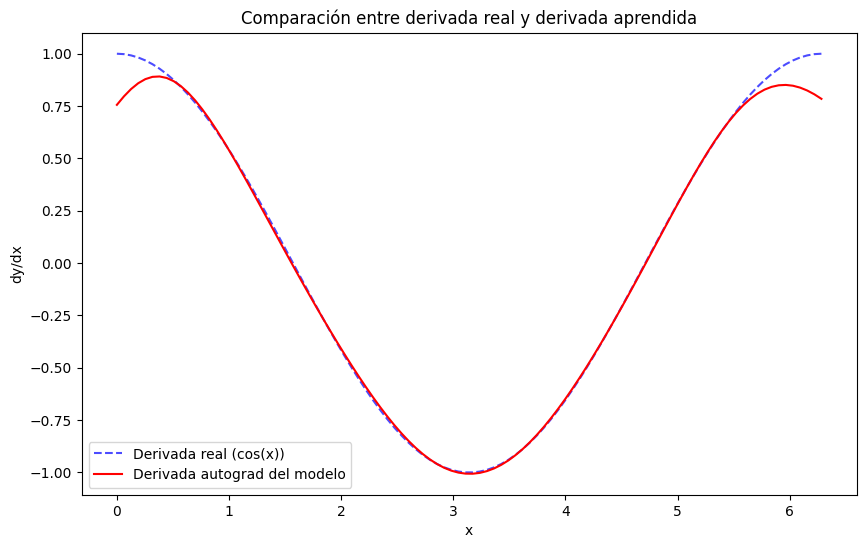

In [12]:
plt.figure(figsize=(10, 6))

# Asegurarse de que x y dy_dx estén en formato NumPy para usar en matplotlib.plt
x = x_test.detach().cpu().numpy()
dy_dx_np = dy_dx.detach().cpu().numpy()

# Graficar derivada real y derivada aprendida
plt.plot(x, np.cos(x), label='Derivada real (cos(x))', linestyle='--', color='blue', alpha=0.7)
plt.plot(x, dy_dx_np, label='Derivada autograd del modelo', color='red')

# Estética del gráfico
plt.title('Comparación entre derivada real y derivada aprendida')
plt.xlabel('x')
plt.ylabel('dy/dx')
plt.legend()
plt.show()


> **Ejercicios extra:**
> 
> * Experimenta con el modelo para explorar cómo responde a distintos escenarios:
>     1. Para una función rapidamente oscilante $$\sin\left(\frac{2n\pi x}{L}\right)$$ con $L=1$ y diferentes valores de $n=5,20,50$. 
>     1. Qué sucede con el modelo?
>     1. Qué rol juega la capacidad del modelo (número de neuronas, activaciones, número de capas)
>     1. Cómo afecta el tamaño del dataset y la densidad de puntos?
> * ¿Cómo se podría calcular la segunda derivada de esta función utilizando autograd en PyTorch?
> 
> $$ \dfrac{d}{dx} \left(\dfrac{d}{dx}\hat{y}(x)\right)$$

In [ ]:
d2y_dx2 = torch.autograd.grad(
    outputs=dy_dx,
    inputs=x_test,
    grad_outputs=torch.ones_like(dy_dx),
)[0]


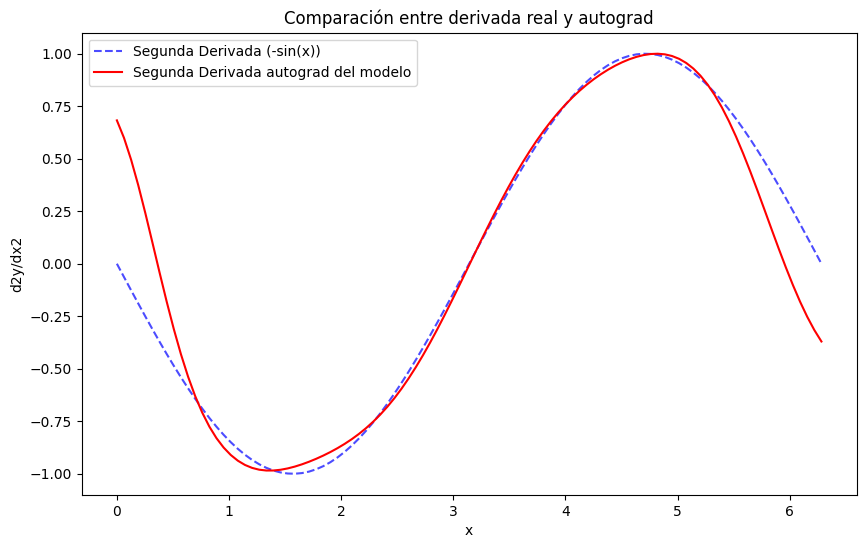

In [14]:
plt.figure(figsize=(10, 6))

# Asegurarse de que x y dy_dx estén en formato NumPy

d2y_dx2_np = d2y_dx2.detach().cpu().numpy()

# Graficar derivada real y derivada aprendida
plt.plot(x, -np.sin(x), label='Segunda Derivada (-sin(x))', linestyle='--', color='blue', alpha=0.7)
plt.plot(x, d2y_dx2_np, label='Segunda Derivada autograd del modelo', color='red')

# Estética del gráfico
plt.title('Comparación entre derivada real y autograd')
plt.xlabel('x')
plt.ylabel('d2y/dx2')
plt.legend()
plt.show()


# <span style="color:#1f77b4;">Ejemplo guiado:</span> Ecuación de Poisson 1D

Queremos resolver la ecuación de Poisson:

$$-\frac{d^2 V}{dx^2} = \rho(x), \quad x \in [0, L] \;, $$
con las siguientes condiciones de borde:

$$V(0) = V(L) = 0 \, .$$

Elegimos una fuente gaussiana:

$$\rho(x) = \exp\left[ -\frac{(x - x_o)^2}{2\sigma^2} \right] $$

con los parámetros:

$$ L = 1, \quad x_o= 0.5, \quad \sigma = 0.1 $$

Esto representa una distribución de carga continua, suave y localizada en ($x_o$).

La solución $V(x)$ representa el potencial producido por esa carga, el cual debería alcanzar su máximo en ($x_o$) y anularse en los bordes, [Más información](https://dn390.user.srcf.net/files/waffle/IA/Vector_Calculus/poisson.pdf).


Este problema admite una solución analítica utilizando la función de Green asociada al operador Laplaciano unidimensional con densidad de carga $\rho(x)$:
$$V(x) = \int_0^L G(x, x') \rho(x') dx'$$
donde la función de Green $ G(x, x')$ para condiciones de borde de Dirichlet es:
\begin{equation}
G(x, x') = \begin{cases} \frac{x(L - x')}{L}, & x < x' \\ \frac{x'(L - x)}{L}, & x > x' \end{cases}
\end{equation}

En la práctica, esta integral puede evaluarse fácilmente de forma numérica utilizando NumPy.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fuente Gaussiana rho(x)
def rho_np(x, xcenter=0, sigma=0.1):
    return np.exp(-0.5 * ((x - xcenter) / sigma) ** 2)

# Función de Green 1D con condiciones de borde tipo Dirichlet en el rango x\in[0,L]
# G(x,x') = x (L - x') / L   if x < x'
#         = x' (L - x) / L   if x >= x'
def green_mat(x, xp):
    # x: posiciones 1D con shape (M,) ; xp: posiciones primas 1D con shape (N,)
    # retorna una matriz (M,N)  G_ij = G(x[i], xp[j])
    x = x[:, None]   # shape (M,1)
    xp = xp[None, :] # shape (1,N)
    mask = (x < xp)
    G = np.where(mask, x * (L - xp) / L, xp * (L - x) / L)
    return G

# Paramemtros iniciales
L = 1.0
xo = 0.5
sigma = 0.1

# Creamos un grid para evaluar la solución
N = 2000
xs = np.linspace(0., L, N) # puntos de evaluación x. shape:(N,)
xsp = np.linspace(0., L, N)            # puntos de integración x'. shape:(N,)

# Calculamos la solución analítica V(x) = \int_0^L G(x,x') rho(x') dx'
rho_vals = rho_np(xsp,xo,sigma)  # # note que estamos evaluando sobre x' para realizar la integral 
G = green_mat(xs, xsp) # shape (N, N)
# podemos usar el metodo del trapecio sobre x'
V_analytic = G.dot(rho_vals)*(xsp[1] - xsp[0])  # shape (N,)

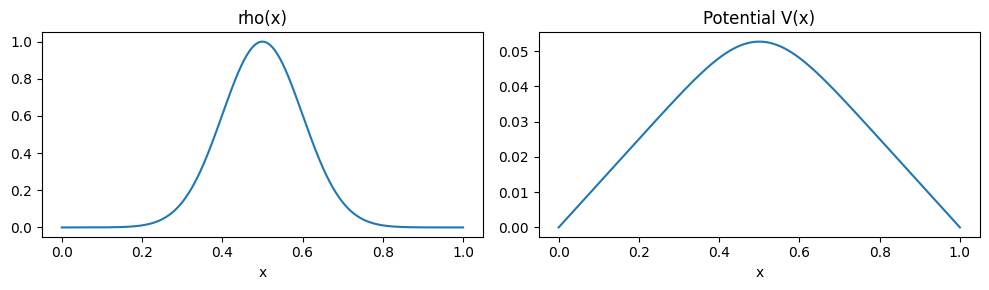

In [16]:
# Graficamos la soluciómn
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(xs, rho_vals)
ax[0].set_title('rho(x)')
ax[0].set_xlabel('x')

ax[1].plot(xs, V_analytic)
ax[1].set_title('Potential V(x)')
ax[1].set_xlabel('x')

plt.tight_layout()
plt.show()


Ahora vamos a implementar PINNs para resolver este problema!

<div style="border-left: 4px solid #4caf50; padding: 8px;">
🔄 <strong>¿Qué cambia respecto al aprendizaje supervisado?</strong>

En el aprendizaje supervisado tradicional, entrenamos el modelo usando pares de datos conocidos
${x_i, y_i}$, donde los valores $y_i$ sirven como *targets* o valores objetivo.

El modelo aprende a aproximar la relación $x_i \mapsto y_i$.

en una PINN pedimos adicionalmente:

* Usamos conocimiento físico expresado en forma de ecuaciones diferenciales (PDEs) que el modelo debe satisfacer.
* También es posible usar formulaciones variacionales, donde el entrenamiento se basa en minimizar un funcional de energía.

</div>

Una PINN transforma un problema de ajuste de datos en un problema de consistencia física, donde buscamos una función $\hat{y}_\theta(x)$ que minimice el residuo de la PDE.
Esto permite entrenar incluso con pocos datos, siempre que tengamos una buena descripción matemática del sistema.



Para entrenar nuestra PINN, vamos a necesitar:

- Un MLP para $V_\theta(x)$, donde $\theta$ son los parametros de la red.

- Definir la función "residuo" de la PDE 
$$R_\theta \equiv V_\theta''(x) + \rho(x)$$

- Incluir las condiciones de Borde 
$$V_\theta(0) = 0, \quad V_\theta(L) = 0 $$

Luego, la función de coste total a minimizar es:
$$\mathcal{L} = \text{MSE}\left(R_\theta \right) + \text{MSE}(\text{B.C.})$$

Explícitamente:

$$\mathcal{L} = \mathcal{L}_{PDE}+\mathcal{L}_{\rm{B.C.}} = \frac{1}{N}\sum_{i}^N\left|\left.\frac{d^2V_\theta (x)}{dx^2}\right|_{x_i} + \rho(x_i)\right|^2 + \rm{w}_b \left[ |V_\theta(0)|^2 + |V_\theta(L)|^2 \right]$$

El parámetro $\rm{w}_b$ cumple un rol crucial: es un factor de ponderación que equilibra la importancia entre el cumplimiento de la PDE y las condiciones de borde

 * Si el término de la PDE domina (valores grandes en comparación con las BC),
  el modelo puede ignorar las condiciones de borde.
 * Si el término de borde domina,
  el modelo podría ajustar las condiciones pero no resolver correctamente la PDE en el interior.

> Por eso, $\rm{w}_b$ controla el balance entre precisión física y consistencia en los bordes.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

if torch.cuda.is_available():
    torch.set_default_device("cuda")
    
class PoissonLoss(nn.Module):
    def __init__(self, L=1.0, w_b=1e3, xo=0.5, sigma=0.1):
        super().__init__()
        self.L = L
        self.w_b = w_b
        self.xo = xo
        self.sigma = sigma

    def rho(self, x):
        return torch.exp(-0.5*((x - self.xo)/self.sigma)**2)

    def forward(self, model, x_dom, xb0, xbL):
        x_dom.requires_grad_(True)

        V = model(x_dom)
        dV_dx = torch.autograd.grad(V, x_dom,
                                    grad_outputs=torch.ones_like(V),
                                    create_graph=True)[0]
        d2V_dx2 = torch.autograd.grad(dV_dx, x_dom,
                                      grad_outputs=torch.ones_like(dV_dx),
                                      create_graph=True)[0]

        rho = self.rho(x_dom)
        pde_res = d2V_dx2 + rho
        pde_loss = torch.mean(pde_res**2)

        # Evaluamos en el borde
        V0 = model(xb0)
        VL = model(xbL)
        bc_loss = torch.mean(V0**2 + VL**2)

        return pde_loss + self.w_b * bc_loss

Reciclamos algunas de las funciones del problema anterior aquí:

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1, 10)          # Fully connected layer: 1 input, 10 hidden units
        self.activation = nn.functional.tanh # Función de activación
        self.fc2 = nn.Linear(10, 1)          # Fully connected layer: 10 hidden units, 1 output

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

def train_epoch(puntos_interior, puntos_borde_0, puntos_borde_L, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    loss = criterion(modelo, puntos_interior, puntos_borde_0, puntos_borde_L)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, x_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(x_test).cpu().numpy()
    return y_pred.squeeze()

In [ ]:
modelo = MLP()
criterio = PoissonLoss(L=L)
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)

num_epocas = 10000
n_dom = 10000

for epoca in range(num_epocas):
    x_dom = torch.rand(n_dom,1)*L
    x_en_0 = torch.zeros((1,1))
    x_en_L = torch.full((1,1), L)

    loss = train_epoch(x_dom, x_en_0, x_en_L, modelo, optimizer, criterio)
    # # Train_epoch
    # modelo.train()
    # optimizer.zero_grad()
    # loss = criterio(modelo, x_dom, x_en_0, x_en_L)
    # loss.backward()
    # optimizer.step()
    # #
    if (epoca+1) % 1000 == 0:
        print(f'Epoch [{epoca+1}/{num_epocas}], Loss: {loss:.4f}')


Epoch 1000/10000, Loss = 1.47e-01
Epoch 2000/10000, Loss = 1.37e-01
Epoch 3000/10000, Loss = 1.22e-01
Epoch 4000/10000, Loss = 1.06e-01
Epoch 5000/10000, Loss = 8.13e-02
Epoch 6000/10000, Loss = 4.52e-02
Epoch 7000/10000, Loss = 3.49e-02
Epoch 8000/10000, Loss = 3.10e-02
Epoch 9000/10000, Loss = 2.25e-02
Epoch 10000/10000, Loss = 1.25e-02


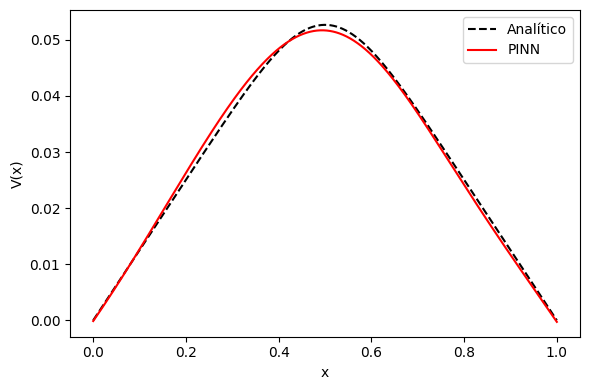

In [ ]:
x_test = torch.tensor(xs[:,None], dtype=torch.float32)

V_pred = evaluate(modelo, x_test)

plt.figure(figsize=(6,4))
plt.plot(xs, V_analytic, 'k--', label='Analítico')
plt.plot(xs, V_pred, 'r', label='PINN')
plt.xlabel('x'); plt.ylabel('V(x)')
plt.legend(); plt.tight_layout(); plt.show()

### Extras:

Una partícula cargada localizada en x_0 se modela como una distribución delta de Dirac: $\rho(x) = \delta_D(x - x_0)$

Para nuestro problema, esta se puede obtener como el límite de la fuente Gaussiana:

$$\rho(x) = \exp\left[ -\frac{(x - x_0)^2}{2\sigma^2} \right] \quad \text{cuando } \sigma \to 0 $$

- Ajuste el código anterior para resolver el problema de la particula cargada.
- Cómo se comporta nuestro modelo para este tipo de densidad?

# <span style="color:#1f77b4;">Ejemplo guiado:</span> Oscilador armónico en 1D

El oscilador armónico amortiguado en 1D: 

$$m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~, $$

con condiciones iniciales: 
$$x(0) = 1, \quad \dfrac{d x}{d t} = 0$$

Nos enfocaremos en resolver el problema en el régimen subamortiguado, es decir, cuando 

$$
\delta < \omega_0 \rightarrow \quad \delta = \dfrac{\mu}{2m},\quad\omega_0 = \sqrt{\dfrac{k}{m}}.
$$

Esto tiene la siguiente solución exacta: 

$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t)),\quad\mathrm{con}\quad \omega=\sqrt{\omega_0^2 - \delta^2}.
$$

[Más información](https://la.mathworks.com/discovery/physics-informed-neural-networks.html)


------------------------------

Vamos a fijar algunas constantes libres del problema

$$m=1,\, \mu=4, k=400 \, \Rightarrow\, \delta=2<\omega_0=400$$

y consideramos el intervalo de tiempo

$$t\in[0,1]$$

Ahora la loss tendremos dos contribuciones:

1. El residuo de la PDE: $R_\theta \equiv m\ddot{x}+\mu\dot{x}+kx$
1. La condicion iniciales: $x(t=0)=1$, y $\dot{x}(t=0)=0$

In [ ]:
class DampedOscillatorLoss(nn.Module):
    def __init__(self, m=1.0, mu=4., k=400.0, w_b=1e3):
        super().__init__()
        self.m, self.mu, self.k = m, mu, k
        self.w_b = w_b

    def forward(self, model, t_dom, t0):
        x = model(t_dom)
        dx_dt = torch.autograd.grad(x, t_dom,
                                    grad_outputs=torch.ones_like(x),
                                    create_graph=True)[0]
        d2x_dt2 = torch.autograd.grad(dx_dt, t_dom,
                                      grad_outputs=torch.ones_like(dx_dt),
                                      create_graph=True)[0]

        # Residue de la PDE
        pde_residual = self.m * d2x_dt2 + self.mu * dx_dt + self.k * x
        pde_loss = torch.mean(pde_residual**2)

        # Condiciones iniciales
        x0 = model(t0)
        dx_dt0 = torch.autograd.grad(x0, t0,
                                     grad_outputs=torch.ones_like(x0),
                                     create_graph=True)[0]

        ic_x_en_t0 = torch.mean(x0 - 1.0)**2
        ic_vel_en_t0 = torch.mean(dx_dt0**2)

        return pde_loss + self.w_b * (ic_x_en_t0+ic_vel_en_t0)

In [22]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t):
        return self.net(t)

In [ ]:
# domain and initial condition points
t_dom = torch.linspace(0, 1, 200, requires_grad=True)[:,None]
t0 = torch.tensor([[0.0]], requires_grad=True)

model = MLP()
criterion = DampedOscillatorLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10000):
    optimizer.zero_grad()
    loss = criterion(model, t_dom, t0)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.2e}")

Epoch 1000: Loss = 9.65e+02
Epoch 2000: Loss = 9.50e+02
Epoch 3000: Loss = 6.89e+02
Epoch 4000: Loss = 3.73e+02
Epoch 5000: Loss = 2.41e+02
Epoch 6000: Loss = 1.64e+02
Epoch 7000: Loss = 1.25e+02
Epoch 8000: Loss = 1.06e+02
Epoch 9000: Loss = 7.06e+01
Epoch 10000: Loss = 3.03e+01


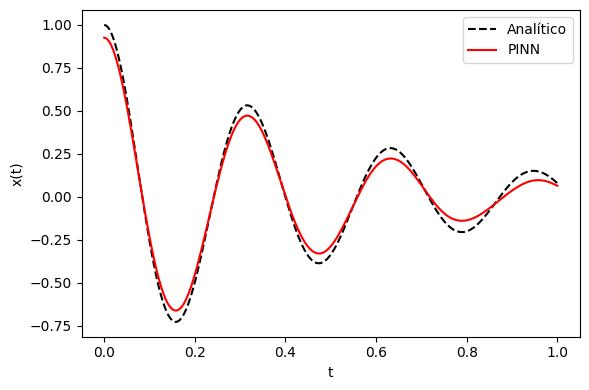

In [ ]:
model.eval()
with torch.no_grad():
    t_test = torch.linspace(0, 1, 200)[:,None]
    x_pred = model(t_test).cpu().numpy().squeeze()

def x_analitico(t, m=1, mu=4, k=400.):
    delta = mu/(2*m)
    omega0 = np.sqrt(k/m)
    omega = np.sqrt(omega0**2 - delta**2)
    A, B = 1.0, delta/omega
    return np.exp(-delta*t)*(A*np.cos(omega*t) + B*np.sin(omega*t))

t = t_test.cpu().numpy().squeeze()
plt.figure(figsize=(6,4))
plt.plot(t, x_analitico(t), 'k--', label='Analítico')
plt.plot(t, x_pred, 'r', label='PINN')
plt.xlabel('t'); plt.ylabel('x(t)')
plt.legend(); plt.tight_layout(); plt.show()


-----------------------------

### Extra:

* Intenta redefinir el MLP para que la salida del modelo tenga la siguiente forma:

$$x(t)= e^{−\delta t} N_\theta(t)$$

donde:

- $N_\theta$ es el valor producido por el modelo secuencial (MLP) para una entrada $(t)$.
- $\delta = \mu/2m$ para este ejercicio lo podemos dar por conocido.
    - Sin embargo, en muchos casos no conocemos su valor exacto, por lo que en rigor debería tratarse como un parámetro adicional a aprender por la red!
    - Como segundo ejercicio, modifica el código para que el MLP también aprenda $\delta$.

¿Cómo ayuda esta reparametrización de la red? ¿Toma más o menos épocas en converger la solución?
¿Mejora el ajuste entre el valor analítico y la solución de nuestro modelo?
¿Vale la pena el trabajo extra?


# <span style="color:#1f77b4;">Ejemplo guiado:</span> Ecuación de Helmholtz

Modelamos una cavidad electromagnética unidimensional de longitud (L) con paredes perfectamente conductoras.

Ecuación diferencial parcial (EDP):

$$\frac{d^2 E(x)}{dx^2} + k^2 E(x) = 0, \quad x \in \Omega = [0, L]$$

Condiciones de borde:

$$ E(0) = 0, \quad E(L) = 0 $$

Solución analítica:

$$ E_n(x) = A \sin\left( \frac{n \pi x}{L} \right), \quad k_n = \frac{n \pi}{L}$$

Entrenaremos una PINN para aprender $E(x)$ para un valor fijo de $k$, por ejemplo $n=1,\,L=1,\, \rightarrow k = \pi$, es decir, el modo fundamental.

[Más información](https://en.wikipedia.org/wiki/Helmholtz_equation)

-------------------------


La PDE define la forma del modo, pero la amplitud es arbitraria ($A$). Como consecuencia, la red puede aprender la solución trivial $E(x)=0$, la cual, por supuesto, también es solución de esta ecuación diferencial. Por lo tanto, a veces necesitamos incluir más información en nuestra función de costo para evitar que se minimice hacia la solución trivial.
Una opción es normalizarla exigiendo que la "energía" (o norma $L^2$) sea igual a $1$:

$$\int_0^L E^2(x) dx = 1$$

Entonces, en forma discreta (usando integración a la monte carlo):

$$\mathcal{L}_{\text{norm}} = \left( \frac{1}{N} \sum_i E^2(x_i) - 1 \right)^2$$

Luego, la pérdida total se convierte en:

$$\mathcal{L} = \mathcal{L}_{\text{PDE}} + \mathcal{L}_{\text{norm}} + \mathcal{L}_\text{B.C}$$

In [ ]:
class HelmholtzLoss(nn.Module):
    def __init__(self, w_b=1, n=1, L=1):
        super(HelmholtzLoss, self).__init__()
        self.w_b = w_b
        self.k = n*torch.pi / L

    def forward(self, model, domain_samples):

        # ----- PDE term -----
        E = model(domain_samples)
        # First derivative dE/dx
        dE_dx = torch.autograd.grad(
            outputs=E,
            inputs=domain_samples,
            grad_outputs=torch.ones_like(E),
            create_graph=True
        )[0]
        # Second derivative d^2E/dx^2
        d2E_dx2 = torch.autograd.grad(
            outputs=dE_dx,
            inputs=domain_samples,
            grad_outputs=torch.ones_like(dE_dx),
            create_graph=True
        )[0]

        # Residual of Helmholtz eqn: E'' + k^2E = 0
        pde_residual = d2E_dx2 + self.k ** 2 * E
        pde_loss = torch.mean(pde_residual ** 2)

        norm = torch.mean(E**2)
        norm_loss = (norm - 1.0)**2

        return pde_loss + self.w_b * norm_loss

Notemos que esta vez no incluimos los términos de borde en la Loss, ya que vamos a introducir otra manera de imponer condiciones de borde: 
>simplemente multiplicar la salida de la red por una función genérica que se anule en el borde.

Por ejemplo, para condiciones de borde tipo Dirichlet, podemos imponer estas condiciones directamente sobre la arquitectura de la red. En lugar de aprender la función en el borde, definimos:

$$E_\theta(x) = f|_{\partial\Omega} \cdot N\theta(x)$$

donde:

-  $N_\theta(x)$ es el valor producido por el modelo secuencial (MLP) para una entrada $x$,

- $f|_{\partial\Omega}$ es una función particular que satisface las condiciones de borde.

En este caso específico, tomando $f|_{\partial\Omega} = x(L - x)$ garantiza que ( $E_\theta(0) = E_\theta(L) = 0 $), cumpliendo así las condiciones de Dirichlet deseadas.

Esto nos permite ahorrarnos el termino de borde en la loss!

In [ ]:
class HelmholtzMLP(nn.Module):
    def __init__(self, L):
        super().__init__()
        self.L = L
        self.fc1 = nn.Linear(1, 10)          # Fully connected layer: 1 input feature, 10 hidden units
        self.activation = nn.functional.tanh # Función de activación
        self.fc2 = nn.Linear(10, 1)          # Fully connected layer: 10 hidden units, 1 output

    def forward(self, x):
        E_x = self.fc1(x)
        E_x = self.activation(E_x)
        E_x = self.fc2(E_x)
        E_x = x * (self.L - x) * E_x   # Enforces E(0)=E(L)=0
        return E_x

reciclamos algunas funciones anteriores,

In [ ]:
def train_epoch(model, optimizer, criterion, inputs):
    model.train()
    optimizer.zero_grad()
    loss = criterion(model, inputs)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, x_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(x_test).cpu().numpy()
    return y_pred.squeeze()


y entranamos nuestro modelo

In [ ]:
num_epochs = 10000
n=1
box_size = 1
num_points = 1000

modelo         = HelmholtzMLP(box_size)
function_coste = HelmholtzLoss(w_b=1, n=n, L=box_size)
optimizador    = optim.Adam(modelo.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    inputs = torch.rand(num_points, 1, requires_grad=True) * box_size
    loss = train_epoch(modelo, optimizador, function_coste, inputs)
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4e}')


Epoch [1000/10000], Loss: 9.7957e-01
Epoch [2000/10000], Loss: 1.0372e-03
Epoch [3000/10000], Loss: 7.4442e-04
Epoch [4000/10000], Loss: 4.5278e-04
Epoch [5000/10000], Loss: 2.9588e-04
Epoch [6000/10000], Loss: 9.4307e-05
Epoch [7000/10000], Loss: 1.4104e-04
Epoch [8000/10000], Loss: 6.5982e-05
Epoch [9000/10000], Loss: 1.8265e-04
Epoch [10000/10000], Loss: 2.3351e-03


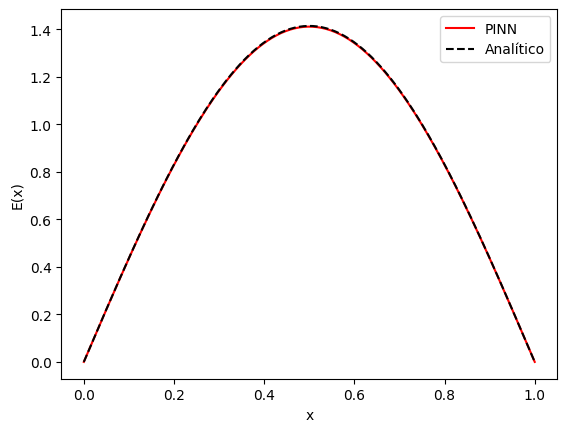

In [ ]:
x_test = torch.linspace(0, box_size, 200)[:,None]
E_pred = evaluate(modelo, x_test)
E_true = np.sqrt(2/box_size)*np.sin(n*np.pi*x_test.cpu().numpy() / box_size)

plt.plot(x_test.squeeze().cpu().numpy() , E_pred.squeeze(), 'red', label='PINN')
plt.plot(x_test.squeeze().cpu().numpy() , E_true.squeeze(), '--', color='k', label='Analítico')
plt.ylabel('E(x)')
plt.xlabel('x')
plt.legend()
plt.show()

# <span style="color:#1f77b4;">Case of study:</span> Poisson en 2D

En el siguiente problema consideramos un sistema con una fuente interna distribuida de forma sinusoidal en ambas direcciones espaciales, descrito por la siguiente ecuación de Poisson:

$$-\Delta u(x) = 8 \pi^2 \sin(2\pi x) \sin(2\pi y)$$

en el dominio cuadrado $x \in \Omega = (-1,1)\times(-1,1)$.

Se imponen condiciones de borde de tipo Dirichlet, especificando que $$ u(x) = 0, \in \partial\Omega .$$

La solución analítica de este problema es:

$$ u(x) = \sin(2\pi x) \sin(2\pi y). $$

In [ ]:
# Tu solución

# <span style="color:#1f77b4;">Case of study:</span> Laplace en 2D con una singularidad de cuña

Consideremos el siguiente problema de Dirichlet para la ecuación de Laplace en el dominio plano $\Omega$,

$$ \Delta u(x) = 0,  \in \Omega$$

con condición de borde dada por:

$$ u(x) = u(r,\theta) = r^{1/2} \sin{\left( \frac{\theta}{2} \right)}, \in \partial\Omega $$

donde el dominio se define como $\Omega = (-1,1)\times(-1,1)\backslash  [0,1) \times \{0\} $.

Este dominio corresponde a un cuadrado con una hendidura (o corte) a lo largo del eje $x$ positivo, desde el origen hasta el punto $(1,0)$, lo que introduce una singularidad tipo cuña en el origen.


La solución analítica de este problema es:

$$ u(x) = r^{1/2} \sin{\left( \frac{\theta}{2} \right)}. $$

donde $(r,\theta )$ son las coordenadas polares centradas en el origen.


In [ ]:
# Tu solución